# Perform decision tree analysis on caluclated SOH1 using IBS signals + charging cycle parameters

In [33]:
import pandas as pd
import numpy as np
import os, sys
from sklearn.model_selection import train_test_split
from pathlib import Path
from datetime import datetime, timezone
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

CYCLE_METRICS_CSV_DIR = Path("outputs/logs") # resolve path

In [34]:
# Read in generated charge cycle metrics data

path = CYCLE_METRICS_CSV_DIR / "cycle_metrics_all.csv"
df = pd.read_csv(path)

print(df.shape)
df.head()

(75, 119)


,cycle_start,cycle_end,source_file,cycle_id,cycle_idx,duration_s,V_peak_charge,V_mean_charge,V_tail_mean,time_absorption_s,...,IBS_Sulfation__last,IBS_BatteryDefect__mean,IBS_BatteryDefect__median,IBS_BatteryDefect__std,IBS_BatteryDefect__min,IBS_BatteryDefect__max,IBS_BatteryDefect__p10,IBS_BatteryDefect__p90,IBS_BatteryDefect__first,IBS_BatteryDefect__last
0,2025-06-26 02:20:47+00:00,2025-06-26 02:40:03+00:00,12V Management 2025-06-25_22-20-47_IBS_only_c...,12V Management 2025-06-25_22-20-47_IBS_only_c...,0,1156.0,14.115,14.106860,14.100594,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2025-06-26 11:24:45+00:00,2025-06-26 12:02:32+00:00,12V Management 2025-06-25_22-20-47_IBS_only_c...,12V Management 2025-06-25_22-20-47_IBS_only_c...,1,2267.0,14.114,14.102164,14.099900,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2025-06-26 13:09:11+00:00,2025-06-26 13:19:50+00:00,12V Management 2025-06-25_22-20-47_IBS_only_c...,12V Management 2025-06-25_22-20-47_IBS_only_c...,2,639.0,14.114,14.104331,14.100833,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2025-06-26 17:47:23+00:00,2025-06-26 18:22:49+00:00,12V_Management_2025-06-26_13-39-25_IBS_only.csv,12V_Management_2025-06-26_13-39-25_IBS_only.csv#0,0,2126.0,14.113,14.096117,14.101900,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2025-06-26 22:55:27+00:00,2025-06-26 22:55:42+00:00,12V_Management_2025-06-26_13-39-25_IBS_only.csv,12V_Management_2025-06-26_13-39-25_IBS_only.csv#1,1,15.0,14.062,14.044375,14.044375,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# Define X and y 
y = df["target_soh1"]   # Use calculated SOH1 for target. 
X = df.drop(["cycle_start", "cycle_end", "source_file", "cycle_id", "target_soh1"], axis=1)
print(X.shape, y.shape)

(75, 114) (75,)


In [36]:
# Split data set into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Train decision tree regressor
dt = DecisionTreeRegressor(max_depth=5, min_samples_split=5, random_state=42).fit(X_train, y_train)

In [38]:
# Evaluate accuracy
y_pred = dt.predict(X_test)

print("mse:", mean_squared_error(y_test, y_pred))
print("r2:", r2_score(y_test, y_pred))


mse: 0.0009749316689635397
r2: 0.5747896109503189


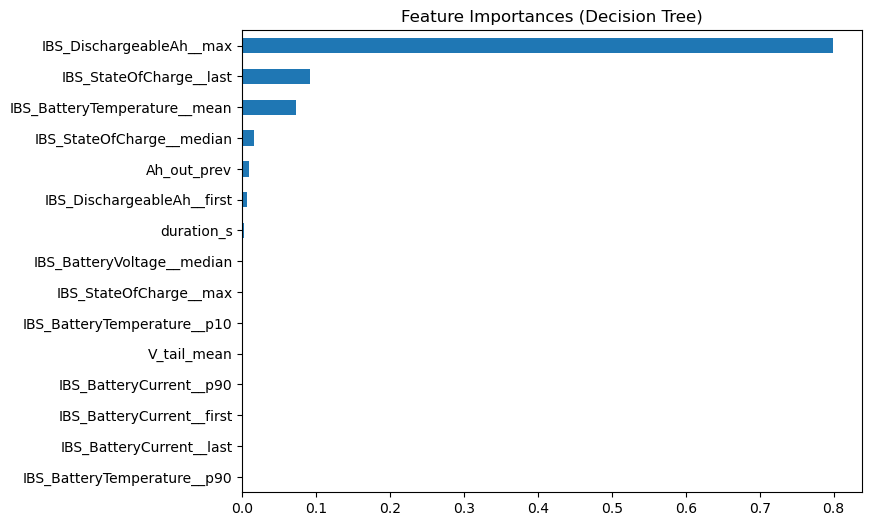

In [39]:
importances = pd.Series(dt.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=True).tail(15)

plt.figure(figsize=(8,6))
importances.plot(kind="barh")
plt.title("Feature Importances (Decision Tree)")
plt.show()

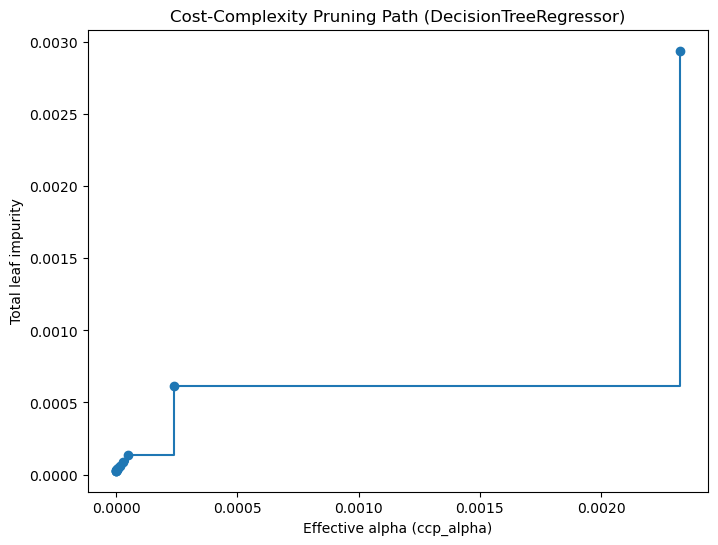

In [40]:
# Get pruning path for your training data
#path = best_dt.cost_complexity_pruning_path(X_train, y_train)

ytr = np.ravel(y_train)

path = dt.cost_complexity_pruning_path(X_train, ytr)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.figure(figsize=(8,6))
plt.plot(ccp_alphas, impurities, marker="o", drawstyle="steps-post")
plt.xlabel("Effective alpha (ccp_alpha)")
plt.ylabel("Total leaf impurity")
plt.title("Cost-Complexity Pruning Path (DecisionTreeRegressor)")
plt.show()

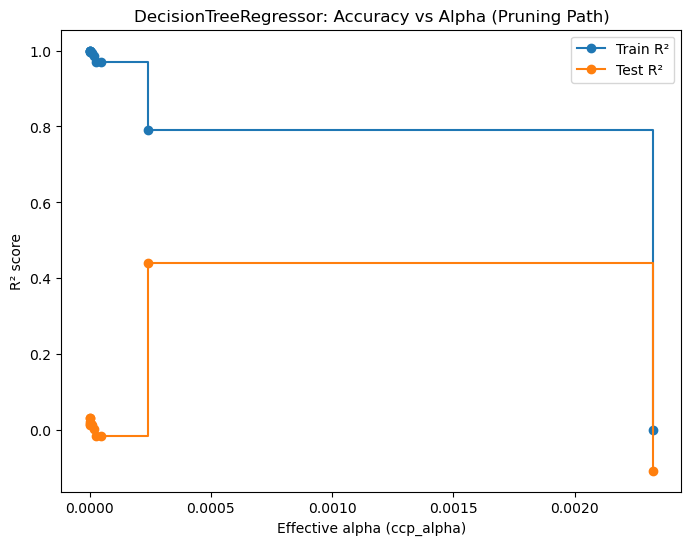

In [41]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

# Compute pruning path
path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

train_scores, test_scores = [], []

# Loop over alphas and fit/prune trees
for alpha in ccp_alphas:
    dt = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha)
    dt.fit(X_train, y_train)
    
    train_scores.append(r2_score(y_train, dt.predict(X_train)))
    test_scores.append(r2_score(y_test, dt.predict(X_test)))

# Plot train vs test R² across alphas
plt.figure(figsize=(8,6))
plt.plot(ccp_alphas, train_scores, marker="o", label="Train R²", drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker="o", label="Test R²", drawstyle="steps-post")
plt.xlabel("Effective alpha (ccp_alpha)")
plt.ylabel("R² score")
plt.title("DecisionTreeRegressor: Accuracy vs Alpha (Pruning Path)")
plt.legend()
plt.show()
